# **Proyecto Final - PDS 2023-2**
### Aplicación de Filtros FIR a Audios de Animales por Método de Enventanado y Método de Muestreo en Frecuencia
<p>Cristian David Charo Morales CC.1061793109</p>
<p>Diego Alonso Quintero Moros CC.1193276339</p>

### **Librerías**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import*
import scipy.signal as signal
from scipy.io.wavfile import read # libreria para lectura de archivos de audio
from IPython.display import Audio # para escuchar la senal
from scipy .io. wavfile import write
from scipy . signal import resample
import scipy.signal as sp
from IPython.display import Image
import pyaudio # Importa la biblioteca PyAudio
import wave
import scipy.signal as sp

##### **Explicación del método de Enventanado**
<p>Para diseñar filtros por el método de Enventanado es necesario especificar algunos parámetros, tales como la frecuencia de muestreo, la frecuencia de corte, el rizado que se desea en el filtro y el ancho de la banda de transición. Luego, a partir de estos se debe realizar algunos cálculos para tomar decisiones acerca de cuál es la ventana ideal para las especificaciones dadas.</p>

<p>Entonces, lo primero es obtener el valor del rizado en dB mediante la siguiente fórmula: 𝑅iple=20log10(𝛿) y a partir del valor obtenido seleccionar la respectiva ventana que mejor se ajuste. Las ventanas se especifican en la siguiente tabla:</p>

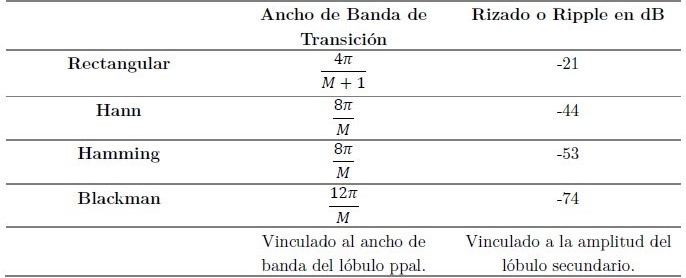

In [18]:
# Especificaciones de cada ventana
Image(filename='Especificaciones de cada ventana.jpg')

<p>También se debe considerar la respectiva ecuación de la ventana elegida:</p>

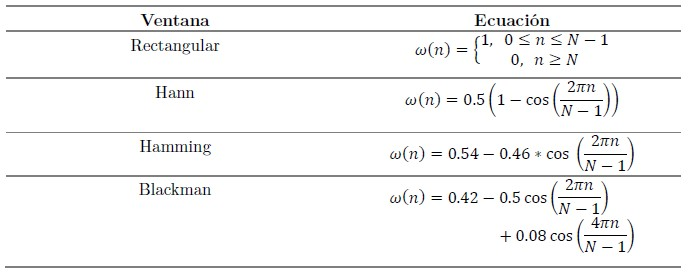

In [17]:
# Ecuación de cada ventana.
Image(filename='Ecuación de cada ventana.jpg')

<p>Después, es necesario escoger la respuesta del filtro ideal según el filtro a diseñar:</p>

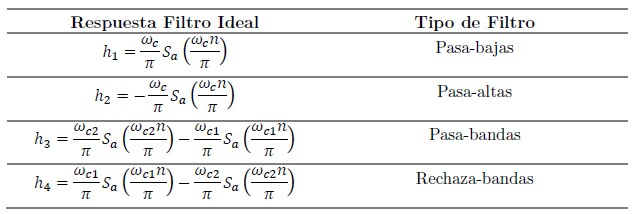

In [19]:
# Respuesta Filtro Ideal
Image(filename='Respuesta Filtro Ideal.jpg')

<p>Finalmente, luego de obtener el respectivo ℎ𝑖𝑖(𝑛𝑛) 𝑦𝑦 𝜔𝜔(𝑛𝑛) se deben multiplicar para obtener ℎ(𝑛𝑛).</p>

### **1.** Filtros FIR por Método de Enventanado

##### **Captura de Audio Real**

In [6]:
# Configuración de la grabación
FORMAT = pyaudio.paInt16  # Formato de audio
CHANNELS = 1  # 1 canal de audio (mono)
RATE = 44100  # Tasa de muestreo en Hz
CHUNK = 1024  # Tamaño del búfer
RECORD_SECONDS = 5  # Duración de la grabación en segundos
OUTPUT_FILE = "Animals.wav"  # Nombre del archivo de salida

# Inicializa PyAudio
audio = pyaudio.PyAudio()

# Abre un nuevo flujo de audio
stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)

print("Grabando...")

frames = []

# Graba el audio en fragmentos
for _ in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("Grabación finalizada")

# Cierra el flujo de audio y PyAudio
stream.stop_stream()
stream.close()
audio.terminate()

# Guarda la grabación en un archivo WAV
with wave.open(OUTPUT_FILE, 'wb') as wf:
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(audio.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))

print(f"Grabación guardada en {OUTPUT_FILE}")

Grabando...
Grabación finalizada
Grabación guardada en Animals.wav


##### **Gráfica y reproducción del Audio Real**

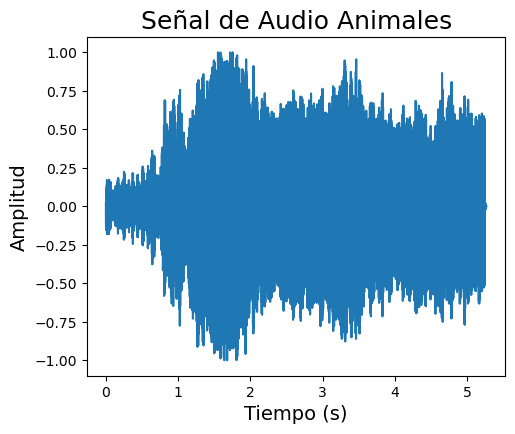

In [3]:
file_audio=('Animals.wav') # Ruta del archivo con la senal
fs, animals_signal=read(file_audio) # Cargar el archivo
animals_signal = animals_signal[:, 0] # Necesario cuando el audio utiliza dos canales
animals_signal=(animals_signal - np.mean(animals_signal))/float(max(abs(animals_signal))) # Escala la amplitud de la senal y elimina DC
t=np.arange(0, (float(len(animals_signal))/fs), 1.0/fs) # Vector de tiempo

plt.figure(figsize=(5.4, 4.4))
plt.plot(t,animals_signal) # Dibujar la grafica
plt.xlabel('Tiempo (s)', fontsize=14) # Etiqueta eje X
plt.ylabel('Amplitud', fontsize=14) # Etiqueta eje Y
plt.title("Señal de Audio Animales", fontsize=18)
plt.show() # Mostrar la grafica
Audio(animals_signal, rate=fs) # para escuchar la señal

<p>Al reproducir el audio se logra escuchar el aullido de un lobo y el cantar de un pájaro, sin embargo, es difícil reconocer si hay más animales o no.</p>

##### **Se grafica el espectro de la señal de audio. Límite la señal en el eje x entre -5000 y 5000 Hz.**

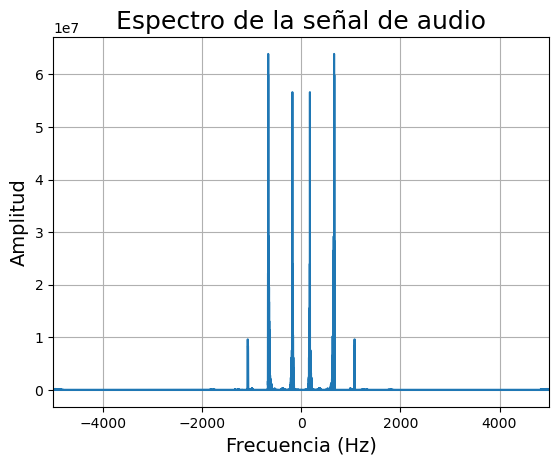

In [9]:
# FFT
ANIMALS_SIGNAL = np.fft.fft(animals_signal)
animals_signal_freq = np.fft.fftfreq(len(animals_signal))*fs

plt.figure()
plt.plot(animals_signal_freq, abs(ANIMALS_SIGNAL)**2)
plt.title('Espectro de la señal de audio', fontsize=18)
plt.xlabel("Frecuencia (Hz)", fontsize=14)
plt.ylabel("Amplitud", fontsize=14)
plt.xlim([-5000, 5000])
# plt.ylim([0, 0.025e7])
plt.grid()

plt.show()

<p>Se observan diversos picos de amplitud para diferentes frecuencias, por lo que es posible separarlos y obtener cada uno de los sonidos de los animales mediante el uso de filtros.</p>

##### **Filtro FIR pasa-bajas mediante el método del enventanado con las siguientes características:**

<ul>
    <li>Frecuencia de muestreo fs = fs_audio</li>
    <li>Frecuencia de corte fc = 300Hz</li>
    <li>Ripple de 0.3%</li>
    <li>Ancho de banda de transición ∆fm = 200 Hz</li>
</ul>

<p>Se especifican las características del filtro pasa bajas:</p>

In [10]:
# Características especificadas del filtro
Fs = fs
print(f"Frecuencia de Muestreo del audio: {Fs} Hz")
Fc_pb = 0.3e3
fm_pb = 200

Frecuencia de Muestreo del audio: 48000 Hz


In [11]:
# Cálculo del Ripple en dB
ripple_dB = 20 * np.log10(0.003)
print("El ripple en dB es:", ripple_dB)

El ripple en dB es: -50.45757490560675


<p>Al obtener un ripple en dB de -50.46 la ventana ideal relación costo-beneficio es la de tipo Hamming. Se calcula entonces el orden del filtro:</p>

In [12]:
M = 4*Fs/fm_pb
if M % 2 == 0:
    M += 1
print('Orden del filtro M (Aproximado al impar superior):', int(M))  

Orden del filtro M (Aproximado al impar superior): 961


<p>Luego, es necesario normalizar la frecuencia de corte en radianes, seleccionar la respuesta del filtro para un pasabajas y la función de la ventana Hamming:</p>

In [13]:
wc_pb = 2*np.pi*Fc_pb/Fs # frecuencia de corte normalizada en radianes
n = np.arange(-M//2+1, M//2+1) # Vector de muestras

hi_pb = wc_pb/np.pi * np.sinc(wc_pb*n/np.pi) # Respuesta del filtro ideal pasa-bajos
hi_pb[M==0] = wc_pb/np.pi

win = 0.54-0.46*np.cos(2*np.pi*np.arange(len(n))/(M-1)) # Ventana de Hamming
h_n_pb = hi_pb*win # Multiplico la respuesta ideal por la ventana
w, h = sp.freqz(h_n_pb, 1, whole=True, worN=2048) # Respuesta en frecuencia del filtro enventanado

<p>Finalmente, se obtiene la gráfica de la respuesta en frecuencia del filtro pasa bajas:

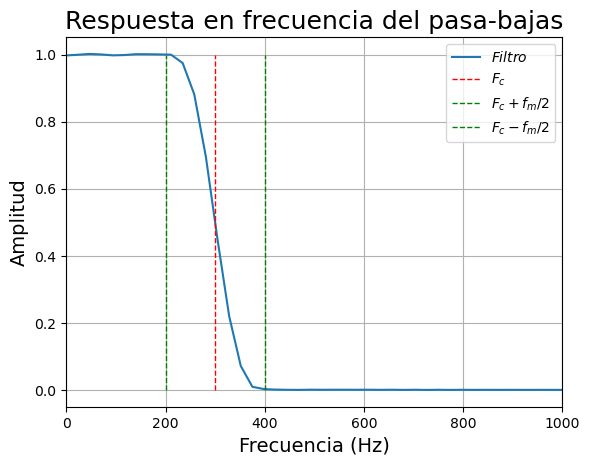

In [14]:
# Grafica para la respuesta en frecuencia del pasa bajas
plt.figure()
plt.title('Respuesta en frecuencia del pasa-bajas', fontsize=18)
plt.plot((w-np.pi)*Fs/(2*np.pi),np.abs(np.fft.fftshift(h)), label='$Filtro$')
plt.vlines(Fc_pb, 0, 1, color='r', lw=1, linestyle='--', label='$F_c$')
plt.vlines(Fc_pb+fm_pb/2, 0, 1, color='g', lw=1, linestyle='--', label='$F_c+f_m/2$')
plt.vlines(Fc_pb-fm_pb/2, 0, 1, color='g', lw=1, linestyle='--', label='$F_c-f_m/2$')
plt.xlabel('Frecuencia (Hz)', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.xlim([0, 1000])
plt.legend()
plt.grid()
plt.show()

<p>Se obtiene que el filtro pasa bajas corta correctamente en 300 Hz y tiene un ancho de banda de transición de aproximadamente 200Hz.</p>

##### **Filtro FIR pasa-bandas mediante el método del enventanado con las siguientes características:**

<ul>
    <li>Frecuencia de muestreo fs = fs_audio</li>
    <li>Frecuencia de corte 1 fc1 = 1.5kHz</li>
    <li>Frecuencia de corte 2 fc2 = 2kHz</li>
    <li>Ripple de 0.7%</li>
    <li>Ancho de banda de transición ∆fm = 100 Hz</li>
</ul>


<p>Se especifican las características del filtro pasa bandas:</p>

In [20]:
# Características especificadas del filtro pasa bandas
Fs = fs
print("Frecuencia de Muestreo del audio: ", Fs)
Fc1_bp = 1.5e3
Fc2_bp = 2e3
fm_bp = 100

Frecuencia de Muestreo del audio:  48000


In [21]:
# Cálculo del Ripple en dB
ripple_dB = 20 * np.log10(0.007)
print("El ripple en dB es:", ripple_dB)

El ripple en dB es: -43.09803919971486


<p>Al obtener un ripple en dB de -43.1 la ventana ideal relación costo-beneficio es la de tipo Hann. Se calcula entonces el orden del filtro:</p>

In [22]:
M = 4*Fs/fm_bp
if M % 2 == 0:
    M += 1
print('Orden del filtro M (Aproximado al impar superior):', int(M))  

Orden del filtro M (Aproximado al impar superior): 1921


<p>Luego, es necesario normalizar la frecuencia de corte en radianes, seleccionar la respuesta del filtro para un pasa bandas y la función de la ventana Hann:</p>

In [23]:
wc1_bp = 2*np.pi*Fc1_bp/Fs # frecuencia de corte 1 normalizada en radianes
wc2_bp = 2*np.pi*Fc2_bp/Fs # frecuencia de corte 2 normalizada en radianes
n = np.arange(-M//2+1, M//2+1) # Vector de muestras

hi_bp = (wc2_bp/np.pi) * np.sinc(wc2_bp*n/np.pi) - (wc1_bp/np.pi) * np.sinc(wc1_bp*n/np.pi) # Respuesta del filtro ideal pasa-bandas
hi_bp[M==0] = (wc2_bp-wc1_bp)/np.pi 

win_bp = 0.5*(1-np.cos(2*np.pi*np.arange(len(n))/(M-1)))# Ventana de Hann
h_n_bp = hi_bp*win_bp # Multiplico la respuesta ideal por la ventana
w, h = sp.freqz(h_n_bp, 1, whole=True, worN=2048) # Respuesta en frecuencia del filtro enventanado

<p>Finalmente, se obtiene la gráfica de la respuesta en frecuencia del filtro pasa bandas:</p>

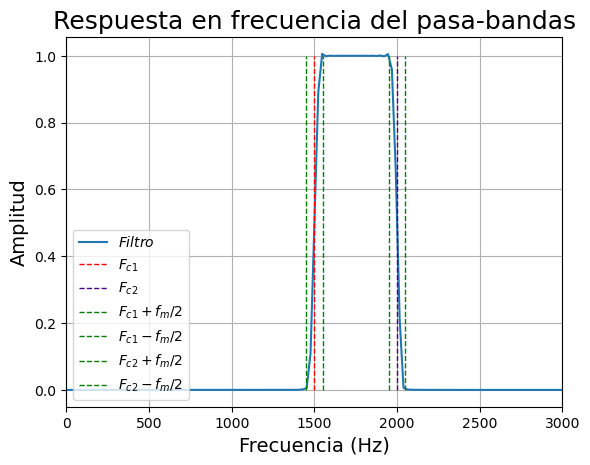

In [33]:
# Grafica de la respuesta en frecuencia del pasa bandas
plt.figure()
plt.title('Respuesta en frecuencia del pasa-bandas', fontsize=18)
plt.plot((w-np.pi)*Fs/(2*np.pi),np.abs(np.fft.fftshift(h)), label='$Filtro$')
plt.vlines(Fc1_bp, 0, 1, color='r', lw=1, linestyle='--', label='$F_{c1}$')
plt.vlines(Fc2_bp, 0, 1, color='indigo', lw=1, linestyle='--', label='$F_{c2}$')
plt.vlines(Fc1_bp+fm_bp/2, 0, 1, color='g', lw=1, linestyle='--', label='$F_{c1}+f_m/2$')
plt.vlines(Fc1_bp-fm_bp/2, 0, 1, color='g', lw=1, linestyle='--', label='$F_{c1}-f_m/2$')
plt.vlines(Fc2_bp+fm_bp/2, 0, 1, color='g', lw=1, linestyle='--', label='$F_{c2}+f_m/2$')
plt.vlines(Fc2_bp-fm_bp/2, 0, 1, color='g', lw=1, linestyle='--', label='$F_{c2}-f_m/2$')
plt.xlabel('Frecuencia (Hz)', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.xlim([0, 3000])
plt.legend(loc='lower left')
plt.grid()
plt.show()

<p>Se obtiene que el filtro pasa bandas corta correctamente en 1500 Hz y 2000 Hz y tiene un ancho de banda de transición de aproximadamente 100Hz.</p>

##### **Explicación del método de Muestreo en Frecuencia**
<p>El muestreo en frecuencia implica tomar N muestras en intervalos definidos por 𝑘(𝐹𝑠/𝑁) con 𝑘=0,1…,(𝑁−1)/2. Además, si se considera que el filtro tendrá fase lineal y respuesta al impulso simétrica y positiva, se tiene que los coeficientes del filtro se pueden obtener así para N par:</p>

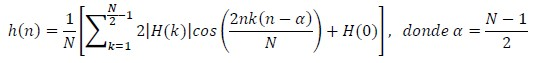

In [38]:
# Coeficientes del filtro
Image(filename='Coeficientes del filtro.jpg')

<p>Si N es un valor impar, entonces el límite superior de la suma será: (𝑁−1)/2.</p>

<p>Además, se debe tener en cuenta que hay dos tipos de muestreo:</p>

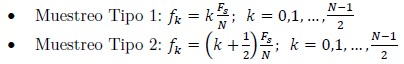

In [39]:
# Tipos de muestreo
Image(filename='Tipos de muestreo.jpg')

### **2.** Filtros FIR por Método de Muestreo en Frecuencia

##### **Filtro FIR pasa-altas mediante el método de muestreo en frecuencia con las siguientes características:**

<ul>
    <li>Frecuencia de muestreo fs = fs_audio</li>
    <li>Frecuencia de corte fc = 4.5kHz</li>
    <li>N = valor de muestras que permita obtener un filtro adecuado</li>
</ul>

<p>Inicialmente se especifican los valores para fs y N. También se selecciona el kmax según el valor de N, el alpha y el paso del muestreo.</p>

In [34]:
# Características
Fs = fs
N = 300
if N % 2 == 0:
    kmax = N//2 - 1 # Si N par
else:
    
    kmax = (N-1)//2 # Si N impar
alpha = (N-1)/2 # Alpha por fórmula
paso = Fs/N # Tamaño de paso para muestrear

<p>Se define la función $\left | H(k) \right|$ que permitirá posteriormente calcular $h(n)$:</p>

In [35]:
# Fórmula para H(k) filtro pasa altas
H_k = []
for k in range(kmax+1):
    if paso*k >= 0 and paso*k <= 4.5e3:  # Entre 0 y 4.5kHz es cero
        H_k.append(0)
    else:                                # A partir de 4.5kHz es uno
        H_k.append(1)

<p>Se realiza el cálculo de $h(n)$ utilizando la fórmula de sumatoria conocida:</p>

In [36]:
# Cálculo de h(n)
h_n_pa = []
for n in range(N):
    suma = 0
    for k in np.arange(1, kmax+1):
        suma += (1/N)*2*H_k[k]*np.cos(2*np.pi*k*(n-alpha)/N)
    suma += (1/N)*H_k[0]
    h_n_pa.append(suma)

<p>Se grafica la respuesta en frecuencia del filtro pasa altas obtenido:</p>

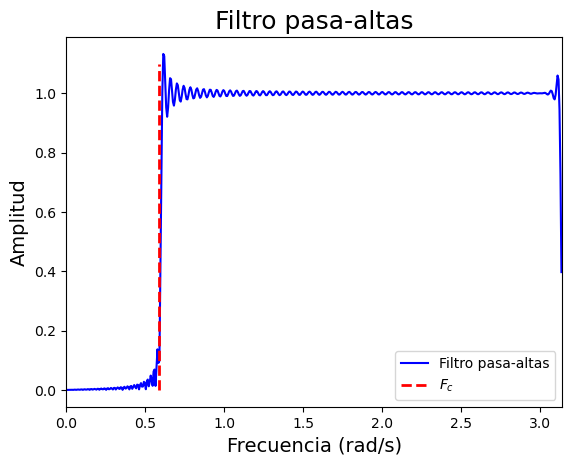

In [45]:
# Gráfica de la respuesta en frecuencia del filtro pasa altas
w, h = sp.freqz(h_n_pa, 1, whole=True, worN=1024)
plt.figure()
plt.title('Filtro pasa-altas', fontsize=18)
plt.plot(w-np.pi, np.abs(np.fft.fftshift(h)), 'b', label='Filtro pasa-altas')
plt.vlines(2*np.pi*4.5e3/Fs, 0, 1.1, color='r', lw=2, linestyle='--', label='$F_c$')
plt.xlabel('Frecuencia (rad/s)', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.xlim([0, np.pi])
plt.legend(loc='best')
plt.show()

<p>Se obtiene que el filtro pasa altas corta correctamente en 4.5 kHz (0.59 en radianes) y se realiza un muestreo correcto al utilizar un N de 300, aunque se presenta el fénomeno de Gibbs, por lo que para reducirlo es necesario utilizar un valor de N más alto, lo cual costará más recursos computacionales.</p>

##### **Filtro FIR rechaza-bandas mediante el método de muestreo en frecuencia con las siguientes características:**

<ul>
    <li>Frecuencia de muestreo fs = fs_audio</li>
    <li>Frecuencia de corte 1 fc1 = 300Hz</li>
    <li>Frecuencia de corte 2 fc2 = 1.6kHz</li>
    <li>N = valor de muestras que permita obtener un filtro adecuado</li>
</ul>

<p>Inicialmente se especifican los valores para fs y N. También se selecciona el kmax según el valor de N, el alpha y el paso del muestreo.<p>

In [38]:
# Características
Fs = fs
N = 1000
if N % 2 == 0:
    kmax = N//2 - 1 # Si N par
else:
    kmax = (N-1)//2 # Si N impar
alpha = (N-1)/2 # Alpha por fórmula
paso = Fs/N # Tamaño de paso para muestrear

<p>Se define la función $\left | H(k) \right |$ que permitirá posteriormente calcular $h(n)$:</p>

In [39]:
# Fórmula para H(k) filtro pasa bandas
H_k = []
for k in range(kmax+1):
    if not (0.3e3 <= paso*k <= 1.6e3):
        H_k.append(1)
    else:
        H_k.append(0)
# H_k

<p>Se realiza el cálculo de $h(n)$ utilizando la fórmula de sumatoria conocida:</p>

In [40]:
# Cálculo de h(n)
h_n_bp2 = []
for n in range(N):
    suma = 0
    for k in np.arange(1, kmax+1):
        suma += (1/N)*2*H_k[k]*np.cos(2*np.pi*k*(n-alpha)/N)
    suma += (1/N)*H_k[0]
    h_n_bp2.append(suma)

<p>Se grafica la respuesta en frecuencia del filtro pasa altas obtenido. Se realiza un zoom entre 0 y $\frac{\pi }{3}$ para facilitar la visualización del filtro:</p>

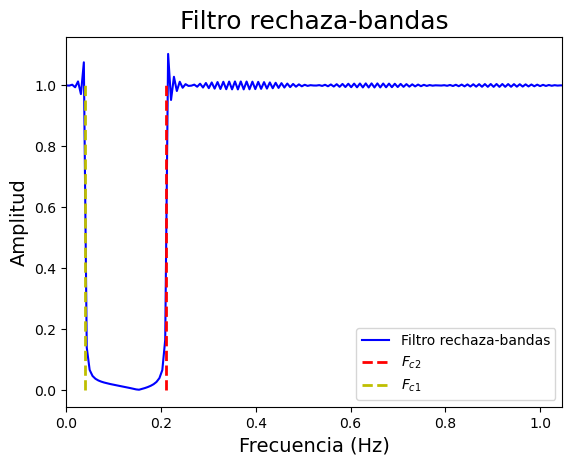

In [46]:
# Gráfica de la respuesta en frecuencia del filtro rechaza bandas
w, h = sp.freqz(h_n_bp2, 1, whole=True, worN=1024)
plt.figure()
plt.title('Filtro rechaza-bandas', fontsize=18)
plt.plot(w-np.pi, np.abs(np.fft.fftshift(h)), 'b', label='Filtro rechaza-bandas')
plt.vlines(2*np.pi*1.6e3/Fs, 0, 1, color='r', lw=2, linestyle='--', label='$F_{c2}$')
plt.vlines(2*np.pi*0.3e3/Fs, 0, 1, color='y', lw=2, linestyle='--', label='$F_{c1}$')
plt.xlabel('Frecuencia (Hz)', fontsize=14)
plt.ylabel('Amplitud', fontsize=14)
plt.xlim([0, np.pi/3])
plt.legend(loc='best')
plt.show()

<p>Se obtiene que el filtro rechaza bandas corta correctamente en 300 Hz (0.039 en radianes) y 1.6kHz (0.21 en radianes) y se realiza un muestreo correcto al utilizar un N de 1000, pero nuevamente se presenta Gibbs.</p>

### **3.** Filtrado de Sonidos Animales con filtros FIR

<p>Se aplica el filtro pasa bajas obtenido en el literal 1 mediante el método de enventanado al audio Animals.wav</p>

In [47]:
# Convolución entre h(n) y la señal de audio y FFT del resultado
y = np.convolve(h_n_pb, animals_signal, mode="same")
Y = np.fft.fft(y)
Y_freq = np.fft.fftfreq(len(Y))*fs

<p>Se reproduce el audio obtenido tras filtrar y se grafica su espectro limitando el eje entre -300 y 300. ¿Qué animal escucha?</p>

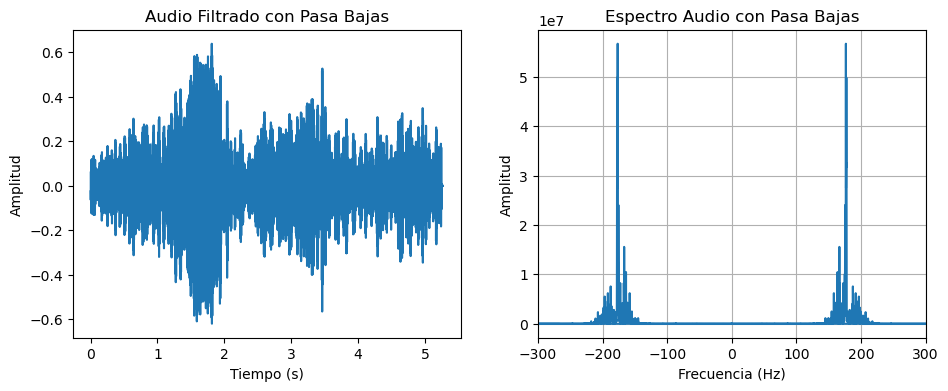

In [48]:
# Gráficas de la señal de audio filtrada con pasa bajas y su espectro
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(t, y)
plt.title("Audio Filtrado con Pasa Bajas")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid

plt.subplot(122)
plt.plot(Y_freq, abs(Y)**2)
plt.title("Espectro Audio con Pasa Bajas")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.xlim([-300, 300])
plt.grid()

plt.show()

Audio(y, rate=fs) # Reproducción del audio filtrado 

<p>Se logra escuchar lo que parece ser una ballena y se suprimen los otros animales. Este sonido tiene una frecuencia muy baja como se puede observar en su espectro, ya que tiene valores entre 150 y 250 Hz aproximadamente. Por esto mismo es que se optó por filtrar con un pasa bajas.</p>

<p>Luego se aplica el filtro pasa bandas obtenido mediante el método de enventanado.</p>

In [49]:
# Convolución entre h(n) y la señal de audio y FFT del resultado
y = np.convolve(h_n_bp, animals_signal, mode="same")
Y = np.fft.fft(y)
Y_freq = np.fft.fftfreq(len(Y))*fs

<p>Se grafica el espectro entre -2500 y 2500.</p>

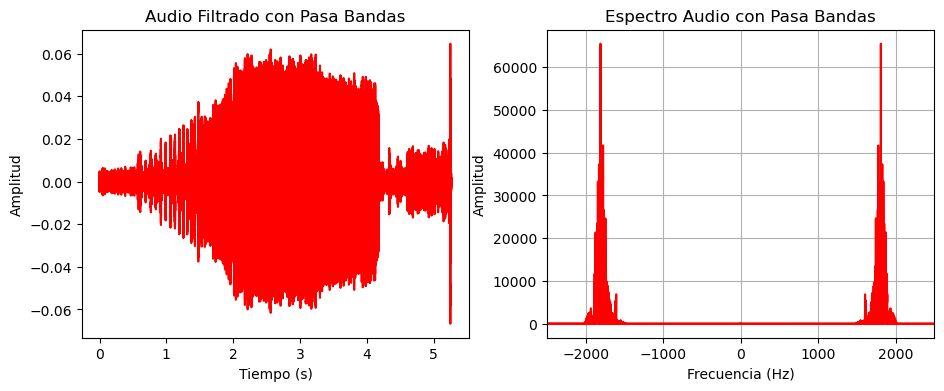

In [50]:
# Gráficas de la señal de audio filtrada con pasa bandas y su espectro
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(t, y, 'r')
plt.title("Audio Filtrado con Pasa Bandas")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid

plt.subplot(122)
plt.plot(Y_freq, abs(Y)**2, 'r')
plt.title("Espectro Audio con Pasa Bandas")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.xlim([-2500, 2500])
plt.grid()

plt.show()

Audio(y, rate=fs) # Reproducción del audio filtrado 

<p>Se logra escuchar lo que parece ser una foca leopardo y se suprimen los otros animales. Como se puede observar en el espectro obtenido, la frecuencia del sonido emitido por este animal está entre 1500 y 2000 Hz aproximadamente. Por esto mismo se utilizó un filtro pasa bandas, de tal forma que solo quedara este rango de frecuencias.</p>

<p>Por consiguiente se aplica el filtro pasa altas obtenido mediante el método de muestreo en frecuencia al audio Animals.wav</p>

In [62]:
# Convolución entre h(n) y la señal de audio y FFT del resultado
y = np.convolve(h_n_pa, animals_signal, mode="same")
Y = np.fft.fft(y)
Y_freq = np.fft.fftfreq(len(Y))*fs

<p>Se reproduce el audio obtenido tras filtrar y se grafica su espectro limitando el eje entre -8000 y 8000. ¿Qué animal escucha?</p>

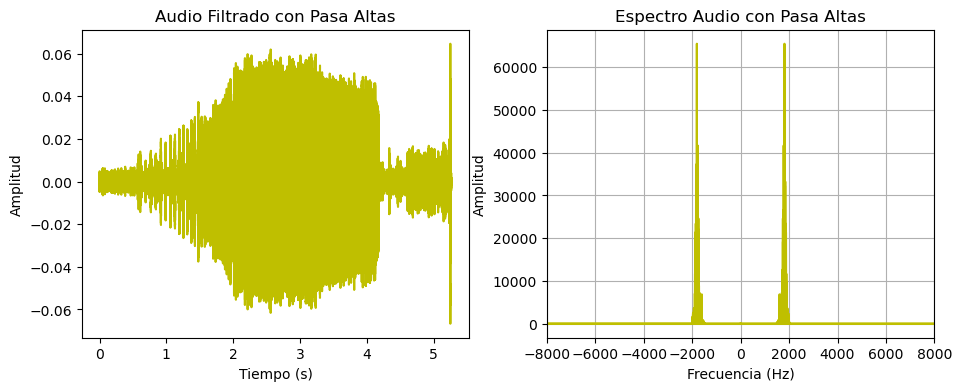

In [51]:
# Gráficas de la señal de audio filtrada pasa altas y su espectro
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(t, y, 'y')
plt.title("Audio Filtrado con Pasa Altas")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid

plt.subplot(122)
plt.plot(Y_freq, abs(Y)**2, 'y')
plt.title("Espectro Audio con Pasa Altas")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.xlim([-8000, 8000])
plt.grid()

plt.show()

Audio(y, rate=fs) # Reproducción del audio filtrado 

<p>Se logra escuchar lo que parece ser el canto de un ave Herrerillo Común (Cyanistes_caeruleus). Como se puede observar en el espectro obtenido, la frecuencia del sonido emitido por este animal está entre 4500 y 7500 Hz aproximadamente. Por esto mismo se utilizó un filtro pasa altas, ya que entre los animales del audio es el que mayor frecuencia presenta.</p>

<p>Finalmente se aplica el filtro rechaza bandas obtenido mediante el método de muestreo en frecuencia.</p>

In [58]:
# Convolución entre h(n) y la señal de audio y FFT del resultado
y = np.convolve(h_n_bp2, animals_signal, mode="same")
Y = np.fft.fft(y)
Y_freq = np.fft.fftfreq(len(Y))*fs

<p>Se grafica el espectro entre -1600 y 1600</p>

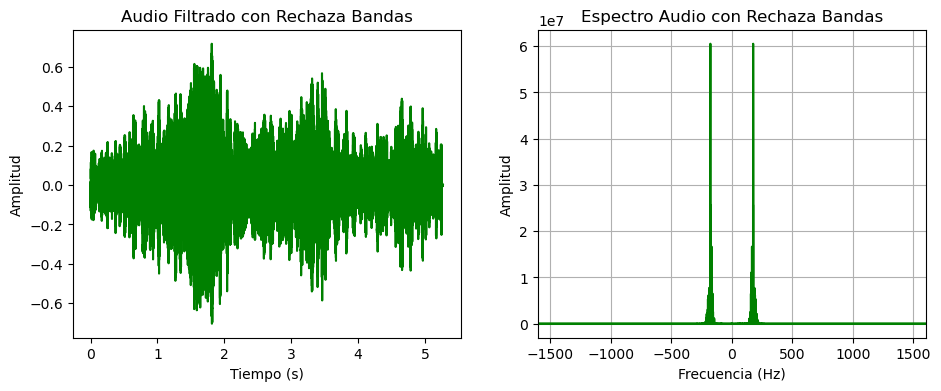

In [59]:
# Gráficas de la señal de audio filtrada rechaza bandas y su espectro
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(t, y, 'g')
plt.title("Audio Filtrado con Rechaza Bandas")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid

plt.subplot(122)
plt.plot(Y_freq, abs(Y)**2, 'g')
plt.title("Espectro Audio con Rechaza Bandas")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.xlim([-1600, 1600])
plt.grid()

plt.show()

Audio(y, rate=fs) # Reproducción del audio filtrado 

<p>Se logra escuchar la ballena y el canto de la ave. Como se puede observar en el espectro obtenido, la frecuencia del sonido emitido por este animal está por fuera del rango entre 300 y 1600 Hz aproximadamente. Debido a esto se optó por un filtro rechaza bandas, ya que este permite filtrar el audio en el rango de frecuencias específico de estos animales.</p>

##### **Explicación del Diseño de Filtros con Respuesta Infinita al Impulso (IIR)**
<p>Un filtro IIR es un tipo de filtro digital en el cual si su entrada es un impulso, la salida será un número ilimitado de términos no nulos, es decir, nunca volverá a un estado de reposo. Para obtener la salida se emplean valores de la entrada actual y anteriores, además se toman valores anteriores de la salida que son almacenados en memoria y realimentados a la entrada. Su expresión en el dominio discreto es:</p>

<p>$y(n) = b_0x(n) + b_1x(n − 1) + . . . + b_Mx(n −M) − a_1y(n − 1) − a_2y(n − 2) − . . . − a_Ny(n − N)$</p>

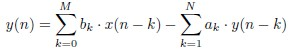

In [47]:
# La cual se puede reducir a:
Image(filename='Expresion filtros IIR.jpg')

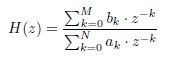

In [48]:
# Además, su función de transferencia en el dominio Z es:
Image(filename='Función de transferencia en el dominio Z.jpg')

### **4.** Filtrado de Sonidos Animales con filtros IIR

<p>Se grafica la señal antes y después de aplicar un filtro IIR pasa-bajas, pasa-altas, pasa-bandas y rechaza-bandas.</p>

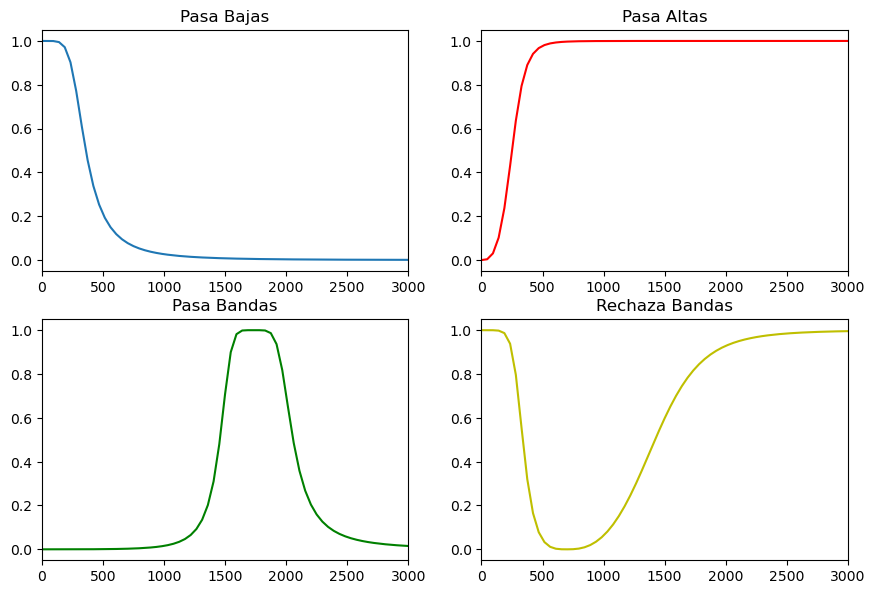

In [46]:
fmax = fs/2
Wn = 300/fmax
plt.figure(figsize=(10.4, 14.4))

# Filtro Pasa Bajas
b, a = sp.butter(3, Wn, btype='lowpass', analog=False, output='ba', fs=None)
wb, Hb = sp.freqz(b, a);
plt.subplot(421)
plt.title("Pasa Bajas")
plt.plot((wb*fs)/(2*np.pi), np.abs(Hb))
plt.xlim([0, 3000])

y_pb = sp.lfilter(b, a, animals_signal)

# Filtro Pasa Altas
b, a = sp.butter(3, Wn, btype='highpass', analog=False, output='ba', fs=None)
wb, Hb = sp.freqz(b, a);
plt.subplot(422)
plt.title("Pasa Altas")
plt.plot((wb*fs)/(2*np.pi), np.abs(Hb), 'r')
plt.xlim([0, 3000])

y_hp = sp.lfilter(b, a, animals_signal)
 
Wn_bajo1 = 1500/fmax
Wn_alto1 = 2000/fmax
    
# Filtro Pasa Bandas
b, a = sp.butter(3, [Wn_bajo1, Wn_alto1], btype='bandpass', analog=False, output='ba', fs=None)
wb, Hb = sp.freqz(b, a);
plt.subplot(423)
plt.title("Pasa Bandas")
plt.plot((wb*fs)/(2*np.pi), np.abs(Hb), 'g')
plt.xlim([0, 3000])

y_bp = sp.lfilter(b, a, animals_signal)

Wn_bajo2 = 300/fmax
Wn_alto2 = 1600/fmax

# Filtro Rechaza Bandas
b, a = sp.butter(3, [Wn_bajo2, Wn_alto2], btype='bandstop', analog=False, output='ba', fs=None)
wb, Hb = sp.freqz(b, a);
plt.subplot(424)
plt.title("Rechaza Bandas")
plt.plot((wb*fs)/(2*np.pi), np.abs(Hb), 'y')
plt.xlim([0, 3000])

y_bs = sp.lfilter(b, a, animals_signal)

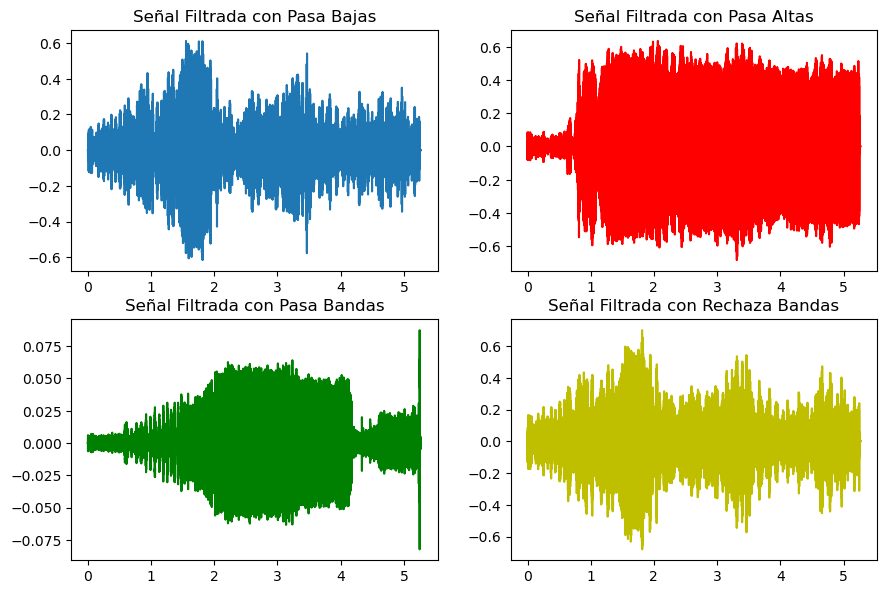

In [39]:
# Señal filtrada con los diferentes tipos de filtros

plt.figure(figsize=(10.4, 14.4))
# Filtro Pasa Bajas
plt.subplot(421)
plt.title("Señal Filtrada con Pasa Bajas")
plt.plot(t, y_pb)

# Filtro Pasa Altas
plt.subplot(422)
plt.title("Señal Filtrada con Pasa Altas")
plt.plot(t, y_hp, 'r')

# Filtro Pasa Bandas
plt.subplot(423)
plt.title("Señal Filtrada con Pasa Bandas")
plt.plot(t, y_bp, 'g')

# Filtro Rechaza Bandas
plt.subplot(424)
plt.title("Señal Filtrada con Rechaza Bandas")
plt.plot(t, y_bs, 'y')

<p>Luego se procede a escuchar los audios al aplicar los diferentes filtros IIR pasa-bajas, pasa-altas, pasa-bandas y rechaza-bandas.</p>

In [40]:
# Convolución entre h(n) y la señal de audio y FFT del resultado
z = np.convolve(y_pb, animals_signal, mode="same")
Z = np.fft.fft(z)
Z_freq = np.fft.fftfreq(len(Z))*fs
Audio(z, rate=fs) # Reproducción del audio filtrado 

In [41]:
# Convolución entre h(n) y la señal de audio y FFT del resultado
z = np.convolve(y_hp, animals_signal, mode="same")
Z = np.fft.fft(z)
Z_freq = np.fft.fftfreq(len(Z))*fs
Audio(z, rate=fs) # Reproducción del audio filtrado 

In [42]:
# Convolución entre h(n) y la señal de audio y FFT del resultado
z = np.convolve(y_bp, animals_signal, mode="same")
Z = np.fft.fft(z)
Z_freq = np.fft.fftfreq(len(Z))*fs
Audio(z, rate=fs) # Reproducción del audio filtrado 

In [43]:
# Convolución entre h(n) y la señal de audio y FFT del resultado
z = np.convolve(y_bs, animals_signal, mode="same")
Z = np.fft.fft(z)
Z_freq = np.fft.fftfreq(len(Z))*fs
Audio(z, rate=fs) # Reproducción del audio filtrado 